# Connect to google account

In [227]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [228]:
# 모듈 Import
import random
import numpy as np # 행렬 계산에 사용하는 모듈
import pandas as pd # 데이터 처리와 분석을 위한 모듈
import matplotlib.pyplot as plt # 데이터 시각화를 위한 모듈. 2D, 3D 그릴 때 사용
import seaborn as sns # 데이터 시각화를 위한 모듈. 두 데이터의 관계를 볼때 사용
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD, NMF, SparsePCA
from sklearn.metrics.pairwise import cosine_similarity

In [229]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/Playdata/Competitions/ML/Dacon/" # 메인 경로
args.apply_train_path = args.default_path + "apply_train.csv" # train 데이터 경로
args.company_path = args.default_path + "company.csv"
args.recruitment_path = args.default_path + "recruitment.csv"
args.resume_certificate_path = args.default_path + "resume_certificate.csv"
args.resume_education_path = args.default_path + "resume_education.csv"
args.resume_language_path = args.default_path + "resume_language.csv"
args.resume_path = args.default_path + "resume.csv"

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로

# 데이터 분석을 위한 변수들
# # 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [230]:
args.submission_path = args.default_path + "result/submission_231105.csv" # 결과 저장 파일
args.save_results = args.default_path+"result/model_results_231105.json" # 결과 저장 json

# File Load

In [231]:
apply_train_df = pd.read_csv(args.apply_train_path) # apply_train -> DataFrame화
company_df = pd.read_csv(args.company_path) # company -> DataFrame화
recruitment_df = pd.read_csv(args.recruitment_path) # recruitment -> DataFrame화
resume_certificate_df = pd.read_csv(args.resume_certificate_path) # resume_certificate -> DataFreame화
resume_education_df = pd.read_csv(args.resume_education_path) # resume_education -> DataFrame화
resume_language_df = pd.read_csv(args.resume_language_path) # resume_language -> DataFrame화
resume_df = pd.read_csv(args.resume_path) # resume -> DataFrame화


In [232]:
apply_train = apply_train_df.copy()
company = company_df.copy()
recruitment = recruitment_df.copy()
resume_certificate = resume_certificate_df.copy()
resume_education = resume_education_df.copy()
resume_language = resume_language_df.copy()
resume = resume_df.copy()

# 탐색

### merged_recruitment 생성

In [233]:
# recruitment, company 정렬(recruitment_seq 기준)
company = company.sort_values(by = "recruitment_seq")
recruitment = recruitment.sort_values(by = "recruitment_seq")

In [234]:
# merged_recruitment = recruitment, company merge
merged_recruitment = pd.merge(recruitment, company, on='recruitment_seq', how='left')
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


### merged_recruitment 탐색 & drop

In [235]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   address_seq2       100 non-null    float64
 3   address_seq3       9 non-null      float64
 4   career_end         6695 non-null   int64  
 5   career_start       6695 non-null   int64  
 6   check_box_keyword  6695 non-null   object 
 7   education          6695 non-null   int64  
 8   major_task         6695 non-null   int64  
 9   qualifications     6695 non-null   int64  
 10  text_keyword       707 non-null    object 
 11  company_type_seq   2377 non-null   float64
 12  supply_kind        2377 non-null   float64
 13  employee           2377 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 784.6+ KB


In [236]:
merged_recruitment.describe()

,address_seq1,address_seq2,address_seq3,career_end,career_start,education,major_task,qualifications,company_type_seq,supply_kind,employee
count,6694.000000,100.000000,9.000000,6695.0,6695.0,6695.000000,6695.000000,6695.000000,2377.000000,2377.000000,2377.000000
mean,3.103675,7.900000,16.555556,0.0,0.0,3.081703,2.277521,1.317401,2.944468,344.090029,217.696676
std,0.955459,7.399836,6.424778,0.0,0.0,0.753074,1.242267,0.477852,1.739406,131.232212,331.153073
min,1.000000,1.000000,3.000000,0.0,0.0,2.000000,1.000000,0.000000,2.000000,100.000000,0.000000
25%,3.000000,1.000000,18.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,41.000000
50%,3.000000,5.000000,20.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,145.000000
75%,3.000000,14.000000,20.000000,0.0,0.0,4.000000,2.000000,2.000000,4.000000,402.000000,300.000000
max,20.000000,20.000000,20.000000,0.0,0.0,6.000000,10.000000,2.000000,9.000000,605.000000,12223.000000


In [237]:
(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq      0.000000
career_end           0.000000
career_start         0.000000
check_box_keyword    0.000000
education            0.000000
major_task           0.000000
qualifications       0.000000
address_seq1         0.000149
company_type_seq     0.644959
supply_kind          0.644959
employee             0.644959
text_keyword         0.894399
address_seq2         0.985063
address_seq3         0.998656
dtype: float64

- 결측치가 90프로 이상인 컬럼 2개 존재
  - address_seq2, address_seq3 : drop 해도 괜찮을 것 같다.
- text_keyword(모집직무키워드) : 키워드 정리할 수 있는 방법
- employee(종업원수), supply_kind(주업종코드), company_type_seq(회사유형코드) : 동일한 index의 값이 결측치다. 분포도를 확인하여 채울 것인지 drop 할건지 결정
- address_seq1(근무지주소) : mode로 해도 될듯하다.

[other col]
- career_start, career_end : 값이 다 없는 상황이기에 drop 해도 괜찮을 것 같다.
- education : 요구학위와 resume의 최종학력과의 관계?
- company_type_seq : 중소, 중견, 대기업 구분?

In [238]:
merged_recruitment_drop_col = ['address_seq2','address_seq3', 'career_start', 'career_end']
merged_recruitment = merged_recruitment.drop(merged_recruitment_drop_col, axis=1)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   text_keyword       707 non-null    object 
 7   company_type_seq   2377 non-null   float64
 8   supply_kind        2377 non-null   float64
 9   employee           2377 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 575.4+ KB


- 결측치
  - address_seq1 : mode

In [239]:
addr_mode = merged_recruitment["address_seq1"].mode().values[0]
merged_recruitment["address_seq1"].fillna(addr_mode, inplace = True)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6695 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   text_keyword       707 non-null    object 
 7   company_type_seq   2377 non-null   float64
 8   supply_kind        2377 non-null   float64
 9   employee           2377 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 575.4+ KB


- 결측치
  - company_type_seq : mode
  - supply_kind, employee : company_type_seq mode값에 맞게 결정

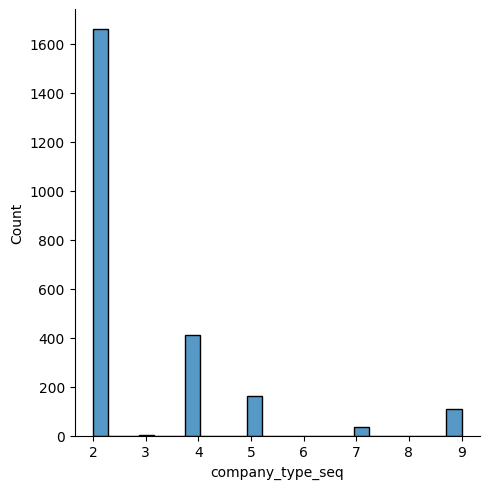

In [240]:
sns.displot(merged_recruitment, x = "company_type_seq")

In [241]:
merged_recruitment["company_type_seq"].value_counts()

2.0    1658
4.0     410
5.0     161
9.0     109
7.0      35
3.0       4
Name: company_type_seq, dtype: int64

In [242]:
company_type_seq_mode = merged_recruitment["company_type_seq"].mode().values[0]
merged_recruitment["company_type_seq"].fillna(company_type_seq_mode, inplace = True)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6695 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   text_keyword       707 non-null    object 
 7   company_type_seq   6695 non-null   float64
 8   supply_kind        2377 non-null   float64
 9   employee           2377 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 833.4+ KB


In [243]:
company_list = merged_recruitment.loc[merged_recruitment["company_type_seq"] == company_type_seq_mode, "supply_kind"].dropna().values
supply_mode = pd.DataFrame(company_list).mode()
supply_mode
supply_mode.values[0][0]

402.0

In [244]:
merged_recruitment["supply_kind"].fillna(supply_mode.values[0][0], inplace = True)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6695 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   text_keyword       707 non-null    object 
 7   company_type_seq   6695 non-null   float64
 8   supply_kind        6695 non-null   float64
 9   employee           2377 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 833.4+ KB


In [245]:
company_em_list = merged_recruitment.loc[merged_recruitment["company_type_seq"] == company_type_seq_mode, "employee"].dropna().values
employee_mode = pd.DataFrame(company_em_list).mode()
employee_mode
employee_mode.values[0][0]

90.0

In [246]:
merged_recruitment["employee"].fillna(employee_mode.values[0][0], inplace = True)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6695 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   text_keyword       707 non-null    object 
 7   company_type_seq   6695 non-null   float64
 8   supply_kind        6695 non-null   float64
 9   employee           6695 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 833.4+ KB


In [247]:
fillna_col = ['text_keyword']

for col in fillna_col: #for문을 돌면서 각 컬럼에 대한 최빈값으로 채움
  col_mode = merged_recruitment[col].mode().values[0]
  merged_recruitment[col].fillna(col_mode, inplace=True)

(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq      0.0
address_seq1         0.0
check_box_keyword    0.0
education            0.0
major_task           0.0
qualifications       0.0
text_keyword         0.0
company_type_seq     0.0
supply_kind          0.0
employee             0.0
dtype: float64

- 중소 / 중소 외 나누기
  - 중소 1 / 중소 외 2

In [248]:
merged_recruitment["company_type_seq"].unique()

array([5., 2., 4., 9., 3., 7.])

In [249]:
company_standard = merged_recruitment["company_type_seq"] == 2.0
merged_recruitment.loc[company_standard, "company_standard"]= 1
merged_recruitment["company_standard"].fillna(2.0, inplace = True)
merged_recruitment["company_standard"] = merged_recruitment["company_standard"].astype('int')
merged_recruitment["company_standard"] = merged_recruitment["company_standard"].astype('category')
merged_recruitment.head()

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee,company_standard
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,영업MD,5.0,201.0,631.0,2
1,R00002,3.0,2507;2703;2707,3,2,1,영업MD,2.0,201.0,160.0,1
2,R00003,3.0,2101;2108;2201;2707,3,2,2,영업MD,2.0,402.0,90.0,1
3,R00004,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,500.0,1
4,R00005,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,90.0,1


In [250]:
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)
object_cols = list(merged_recruitment_object.columns)

for col in object_cols:
  merged_recruitment[col] = merged_recruitment[col].astype('category')

#형 변환 확인
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   recruitment_seq    6695 non-null   category
 1   address_seq1       6695 non-null   float64 
 2   check_box_keyword  6695 non-null   category
 3   education          6695 non-null   int64   
 4   major_task         6695 non-null   int64   
 5   qualifications     6695 non-null   int64   
 6   text_keyword       6695 non-null   category
 7   company_type_seq   6695 non-null   float64 
 8   supply_kind        6695 non-null   float64 
 9   employee           6695 non-null   float64 
 10  company_standard   6695 non-null   category
dtypes: category(4), float64(4), int64(3)
memory usage: 1.0 MB


### merged_resume 생성

In [251]:
# resume 정렬 (resume_seq 기준)
resume = resume.sort_values(by='resume_seq')

In [252]:
# resume_certificate 정렬 (resume_seq 기준)
resume_certificate = resume_certificate.sort_values(by='resume_seq')
# certificate_contents에 결측값이 존재하는 행 제거
resume_certificate = resume_certificate.dropna(subset=['certificate_contents'])
# 이력서번호(resume_seq)기준으로 groupby
# 이력서번호(resume_seq)의 해당하는 자격증들을 세미콜론(;)으로 join해서 적용(apply)
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()

In [253]:
# resume_education 정렬 (resume_seq 기준)
resume_education = resume_education.sort_values(by='resume_seq')

In [254]:
# resume_language 정렬 (resume_seq 기준)
resume_language = resume_language.sort_values(by='resume_seq')
# resume_seq, lanauge;exam_name;score
# lanauge;exam_name;score값을 넣을 컬럼 생성
resume_language['lang_exam_score'] = resume_language['language'].astype(str) + ';' + resume_language['exam_name'].astype(str) + ';' + resume_language['score'].astype(str)
# 기존 lanauge, exam_name, score 컬럼 삭제
resume_language = resume_language.drop(['language','exam_name', 'score', 'score'], axis=1)
# lang_exam_score 에 결측값이 존재하는 행 제거
resume_language = resume_language.dropna(subset=['lang_exam_score'])
# 한 유저가 여러개 자격증정보를 가지고 있으니 &로 묶기
resume_language = resume_language.groupby('resume_seq')['lang_exam_score'].apply('&'.join).reset_index()

In [255]:
# merged_resume = resume, resume_certificate, resume_education, resume_language
merged_resume = pd.merge(resume, resume_certificate, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_education, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_language, on='resume_seq', how='left')
merged_resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,...,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score,lang_exam_score
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,4,5,5,0,17,NaN,NaN,9,20.0,NaN
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,...,0,5,5,0,3,NaN,NaN,8,90.0,NaN
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,...,6,5,5,0,17,NaN,NaN,4,90.0,NaN
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,...,5,5,5,0,5,NaN,NaN,3,70.0,2;11;661.62
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,...,5,0,0,0,0,NaN,NaN,10,50.0,2;4;873.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,...,3,5,5,0,5,NaN,NaN,19,0.0,NaN
8478,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,...,3,3,6,0,3,가정과,NaN,9,0.0,NaN
8479,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,...,0,5,5,0,10,미술대학섬유패션코디네이션학과,NaN,9,80.0,NaN
8480,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,5,5,5,0,5,NaN,NaN,9,60.0,NaN


### merged_resume 탐색 & drop

In [256]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   resume_seq             8482 non-null   object 
 1   reg_date               8482 non-null   object 
 2   updated_date           8482 non-null   object 
 3   degree                 8482 non-null   int64  
 4   graduate_date          8482 non-null   int64  
 5   hope_salary            8482 non-null   float64
 6   last_salary            8482 non-null   float64
 7   text_keyword           8287 non-null   object 
 8   job_code_seq1          8482 non-null   object 
 9   job_code_seq2          500 non-null    object 
 10  job_code_seq3          187 non-null    object 
 11  career_month           8482 non-null   int64  
 12  career_job_code        7724 non-null   object 
 13  certificate_contents   5976 non-null   object 
 14  hischool_type_seq      8482 non-null   int64  
 15  hisc

In [257]:
merged_resume.describe()

,degree,graduate_date,hope_salary,last_salary,career_month,hischool_type_seq,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_transfer,univ_location,univ_major_type,univ_score
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000
mean,3.938222,1819.586065,1395.095496,2505.706201,69.408984,16.402499,5.738387,4.204551,4.684626,0.004480,6.651733,8.095143,71.380350
std,0.440764,584.009224,1865.951253,2010.082733,63.547948,8.485975,4.886454,1.608187,1.892880,0.066787,5.272027,5.152574,20.418688
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2001.000000,0.000000,0.000000,18.000000,20.000000,3.000000,5.000000,5.000000,0.000000,3.000000,4.000000,70.000000
50%,4.000000,2007.000000,0.000000,2700.000000,53.000000,21.000000,4.000000,5.000000,5.000000,0.000000,5.000000,9.000000,80.000000
75%,4.000000,2011.000000,2700.000000,3700.000000,108.000000,21.000000,9.000000,5.000000,5.000000,0.000000,10.000000,9.000000,80.000000
max,6.000000,2022.000000,10000.000000,10000.000000,432.000000,23.000000,18.000000,6.000000,12.000000,1.000000,19.000000,23.000000,100.000000


In [258]:
merged_resume.columns

Index(['resume_seq', 'reg_date', 'updated_date', 'degree', 'graduate_date',
       'hope_salary', 'last_salary', 'text_keyword', 'job_code_seq1',
       'job_code_seq2', 'job_code_seq3', 'career_month', 'career_job_code',
       'certificate_contents', 'hischool_type_seq', 'hischool_special_type',
       'hischool_nation', 'hischool_gender', 'hischool_location_seq',
       'univ_type_seq1', 'univ_type_seq2', 'univ_transfer', 'univ_location',
       'univ_major', 'univ_sub_major', 'univ_major_type', 'univ_score',
       'lang_exam_score'],
      dtype='object')

In [259]:
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_gender          0.000000
hischool_nation          0.000000
hischool_special_type    0.000000
hischool_type_seq        0.000000
univ_score               0.000000
career_month             0.000000
univ_type_seq2           0.000000
univ_location            0.000000
job_code_seq1            0.000000
last_salary              0.000000
hope_salary              0.000000
graduate_date            0.000000
degree                   0.000000
updated_date             0.000000
reg_date                 0.000000
univ_major_type          0.000000
univ_transfer            0.000000
text_keyword             0.022990
career_job_code          0.089366
certificate_contents     0.295449
univ_major               0.788375
lang_exam_score          0.903325
job_code_seq2            0.941052
univ_sub_major           0.950955
job_code_seq3            0.977953
dtype: float64

- 결측치가 90프로 이상인 컬럼이 4개 존재
  - job_code_seq2, job_code_seq3(희망직무) : drop 해도 괜찮을 것 같다.
  - univ_sub_major(부전공) : drop 해도 괜찮을 것 같다.
  - lang_exam_score(언어,시험종류,점수) : 새로 만든 feature, 언어자격증 유무로 해야할지, drop 해야할지?

- univ_major(전공) : univ_type_seq 때문에 결측치가 많아 보인다. => drop 해도 괜찮을 것 같다.
- certificate_contents(자격증) : 자격증 유무?, 자격증 갯수, 키워드 정리할 수 있는 방법
- career_job_code(경력직무) : 키워드 정리할 수 있는 방법
- text_keyword(직무키워드) : 키워드 정리할 수 있는 방법

[other col]

- updated_date, reg_date : 굳이 학습할 필요가 있을까?
- hischool_location_seq : 고등학교 지역코드 기준으로 달라질까?
- univ_type_seq1 : 대학종류로 기준

<Axes: >

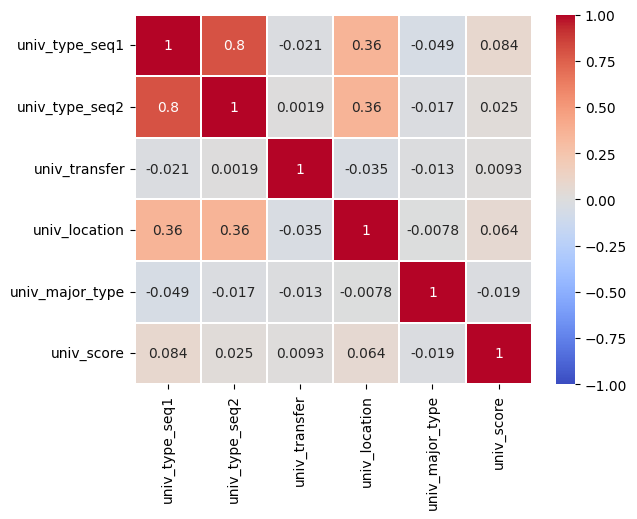

In [260]:
col = merged_resume[['univ_type_seq1', 'univ_type_seq2',
                         'univ_transfer', 'univ_location',
                         'univ_major_type', 'univ_score']]

sns.heatmap(col.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

In [261]:
merged_resume_drop_col = ['job_code_seq2', 'job_code_seq3', # 결측치 다수
                          'univ_major', 'univ_sub_major', 'univ_type_seq2'] # univ_type_seq1에 다 포함되어 있는 것 같다.(상광관계가 높다)
merged_resume = merged_resume.drop(merged_resume_drop_col, axis=1)
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
univ_transfer            0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_gender          0.000000
hischool_nation          0.000000
hischool_special_type    0.000000
hischool_type_seq        0.000000
univ_score               0.000000
univ_location            0.000000
univ_major_type          0.000000
job_code_seq1            0.000000
last_salary              0.000000
hope_salary              0.000000
graduate_date            0.000000
degree                   0.000000
updated_date             0.000000
reg_date                 0.000000
career_month             0.000000
text_keyword             0.022990
career_job_code          0.089366
certificate_contents     0.295449
lang_exam_score          0.903325
dtype: float64

- lang_exam_score : 언어 자격증을 가지고 있는지 유무로 나누자
  - 언어 자격증 소유 : 1 / 미소유 : 0
- certificate_contents : 자격증을 가지고 있는지 유무로 나누자
  - 자격증 소유 : 1 / 미소유 : 0
- certificate_contents의 갯수가 중요할까?

In [262]:
merged_resume["lang_exist"] = 0
merged_resume.loc[merged_resume["lang_exam_score"].notna(), "lang_exist"] = 1
merged_resume["lang_exist"] = merged_resume["lang_exist"].astype('category')
merged_resume.head()

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,career_month,...,hischool_nation,hischool_gender,hischool_location_seq,univ_type_seq1,univ_transfer,univ_location,univ_major_type,univ_score,lang_exam_score,lang_exist
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,0,...,공립,여자학교,4,5,0,17,9,20.0,NaN,0
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,73,...,기타,기타,0,5,0,3,8,90.0,NaN,0
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,113,...,공립,남여공학,6,5,0,17,4,90.0,NaN,0
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,27,...,공립,남여공학,5,5,0,5,3,70.0,2;11;661.62,1
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,0,...,공립,여자학교,5,0,0,0,10,50.0,2;4;873.74,1


In [263]:
merged_resume["certificate_exist"] = 0
merged_resume.loc[merged_resume["certificate_contents"].notna(), "certificate_exist"] = 1
merged_resume["certificate_exist"] = merged_resume["certificate_exist"].astype('category')

merged_resume.head()

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,career_month,...,hischool_gender,hischool_location_seq,univ_type_seq1,univ_transfer,univ_location,univ_major_type,univ_score,lang_exam_score,lang_exist,certificate_exist
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,0,...,여자학교,4,5,0,17,9,20.0,NaN,0,0
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,73,...,기타,0,5,0,3,8,90.0,NaN,0,1
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,113,...,남여공학,6,5,0,17,4,90.0,NaN,0,1
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,27,...,남여공학,5,5,0,5,3,70.0,2;11;661.62,1,1
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,0,...,여자학교,5,0,0,0,10,50.0,2;4;873.74,1,0


- certificate_contents  갯수

In [264]:
merged_resume["certificate_contents"][0]

nan

In [265]:
merged_resume["certificate_cnt"] = 0

# if merged_resume["certificate_contents"].notna():
#   split_str = merged_resume["certificate_contents"].split(";")
#   merged_resume["certificate_cnt"] = len(split_str)

for i, row in merged_resume.iterrows():
  if pd.notna(row["certificate_contents"]):
    split_str = row["certificate_contents"].split(";")
    merged_resume.at[i, "certificate_cnt"] = len(split_str)

merged_resume[["certificate_contents", "certificate_cnt"]]

,certificate_contents,certificate_cnt
0,NaN,0
1,자동차 운전면허 (2종 보통),1
2,운전면허2종보통;컬러리스트 기사;워드프로세서 1급,3
3,정보처리기능사;유통관리사 2급;MOS EXCEL 2003 EXPERT,3
4,NaN,0
...,...,...
8477,NaN,0
8478,컴퓨터그래픽스운용기능사,1
8479,2종 보통 운전면허증;컴퓨터그래픽스운용기능사;컬러리스트기사;컴퓨터패션디자인운용마스터,4
8480,컴퓨터활용능력 2급,1


In [266]:
# lang_exam_score, certificate_contents 삭제
drop_col = ['lang_exam_score', 'certificate_contents']
merged_resume = merged_resume.drop(drop_col, axis=1)
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
lang_exist               0.000000
univ_score               0.000000
univ_major_type          0.000000
univ_location            0.000000
univ_transfer            0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_gender          0.000000
hischool_nation          0.000000
hischool_special_type    0.000000
hischool_type_seq        0.000000
career_month             0.000000
job_code_seq1            0.000000
last_salary              0.000000
hope_salary              0.000000
graduate_date            0.000000
degree                   0.000000
updated_date             0.000000
reg_date                 0.000000
certificate_exist        0.000000
certificate_cnt          0.000000
text_keyword             0.022990
career_job_code          0.089366
dtype: float64

In [267]:
fillna_col = ['text_keyword', 'career_job_code']

for col in fillna_col: #for문을 돌면서 각 컬럼에 대한 최빈값으로 채움
  col_mode = merged_resume[col].mode().values[0]
  merged_resume[col].fillna(col_mode, inplace=True)

(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.0
lang_exist               0.0
univ_score               0.0
univ_major_type          0.0
univ_location            0.0
univ_transfer            0.0
univ_type_seq1           0.0
hischool_location_seq    0.0
hischool_gender          0.0
hischool_nation          0.0
hischool_special_type    0.0
hischool_type_seq        0.0
career_job_code          0.0
career_month             0.0
job_code_seq1            0.0
text_keyword             0.0
last_salary              0.0
hope_salary              0.0
graduate_date            0.0
degree                   0.0
updated_date             0.0
reg_date                 0.0
certificate_exist        0.0
certificate_cnt          0.0
dtype: float64

In [268]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   resume_seq             8482 non-null   object  
 1   reg_date               8482 non-null   object  
 2   updated_date           8482 non-null   object  
 3   degree                 8482 non-null   int64   
 4   graduate_date          8482 non-null   int64   
 5   hope_salary            8482 non-null   float64 
 6   last_salary            8482 non-null   float64 
 7   text_keyword           8482 non-null   object  
 8   job_code_seq1          8482 non-null   object  
 9   career_month           8482 non-null   int64   
 10  career_job_code        8482 non-null   object  
 11  hischool_type_seq      8482 non-null   int64   
 12  hischool_special_type  8482 non-null   object  
 13  hischool_nation        8482 non-null   object  
 14  hischool_gender        8482 non-null   o

In [269]:
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_resume_object = merged_resume.select_dtypes(exclude=np.number)
object_cols = list(merged_resume_object.columns)

for col in object_cols:
  merged_resume[col] = merged_resume[col].astype('category')

#형 변환 확인
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   resume_seq             8482 non-null   category
 1   reg_date               8482 non-null   category
 2   updated_date           8482 non-null   category
 3   degree                 8482 non-null   int64   
 4   graduate_date          8482 non-null   int64   
 5   hope_salary            8482 non-null   float64 
 6   last_salary            8482 non-null   float64 
 7   text_keyword           8482 non-null   category
 8   job_code_seq1          8482 non-null   category
 9   career_month           8482 non-null   int64   
 10  career_job_code        8482 non-null   category
 11  hischool_type_seq      8482 non-null   int64   
 12  hischool_special_type  8482 non-null   category
 13  hischool_nation        8482 non-null   category
 14  hischool_gender        8482 non-null   c

### merged_total = apply_train + merged_recruitment + merged_resume

In [270]:
#컬럼이 너무 많아 헷갈려서 recruitment 데이터에는 'rc_' 추가
rc_columns = ['rc_' + x for x in merged_recruitment.columns]
merged_recruitment.rename(columns=dict(zip(merged_recruitment.columns, rc_columns)), inplace=True)
merged_recruitment

,rc_recruitment_seq,rc_address_seq1,rc_check_box_keyword,rc_education,rc_major_task,rc_qualifications,rc_text_keyword,rc_company_type_seq,rc_supply_kind,rc_employee,rc_company_standard
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,영업MD,5.0,201.0,631.0,2
1,R00002,3.0,2507;2703;2707,3,2,1,영업MD,2.0,201.0,160.0,1
2,R00003,3.0,2101;2108;2201;2707,3,2,2,영업MD,2.0,402.0,90.0,1
3,R00004,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,500.0,1
4,R00005,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,90.0,1
...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,영업MD,2.0,402.0,90.0,1
6691,R06692,3.0,2201;2507,3,2,2,영업MD,4.0,402.0,150.0,2
6692,R06693,5.0,2102;2707,4,2,1,영업MD,2.0,402.0,90.0,1
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,영업MD,2.0,402.0,90.0,1


In [271]:
#apply_train과 merged_recruitment를 merge한 뒤, 필요없는 rc_recruitment_seq drop
_merged_total = pd.merge(apply_train, merged_recruitment, left_on='recruitment_seq', right_on='rc_recruitment_seq', how='left')
_merged_total.drop('rc_recruitment_seq', axis = 1, inplace=True)
_merged_total

,resume_seq,recruitment_seq,rc_address_seq1,rc_check_box_keyword,rc_education,rc_major_task,rc_qualifications,rc_text_keyword,rc_company_type_seq,rc_supply_kind,rc_employee,rc_company_standard
0,U05833,R03838,3.0,2110;2203;2204;2299,3,2,1,영업MD,2.0,402.0,90.0,1
1,U06456,R02144,3.0,2204;2507;2707,3,2,1,영업MD,2.0,402.0,90.0,1
2,U07807,R01877,3.0,2507;2707,3,2,1,영업MD,4.0,402.0,150.0,2
3,U04842,R02463,3.0,2507;2707,4,2,1,영업MD,2.0,402.0,90.0,1
4,U08336,R00112,3.0,2507;2707,3,8,1,영업MD,2.0,402.0,90.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
57941,U02270,R03430,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,90.0,1
57942,U02640,R04987,3.0,2707;2507,3,2,1,영업MD,2.0,402.0,90.0,1
57943,U08238,R01342,3.0,2201;2204;2205;2707,2,2,1,영업MD,4.0,402.0,150.0,2
57944,U01296,R06363,3.0,2201;2204;2205;2707,3,2,1,영업MD,2.0,402.0,90.0,1


In [272]:
#resume 관련 데이터에는 'rs_' 붙임
rs_columns = ['rs_' + x for x in merged_resume.columns]
merged_resume.rename(columns=dict(zip(merged_resume.columns, rs_columns)), inplace=True)
merged_resume

,rs_resume_seq,rs_reg_date,rs_updated_date,rs_degree,rs_graduate_date,rs_hope_salary,rs_last_salary,rs_text_keyword,rs_job_code_seq1,rs_career_month,...,rs_hischool_gender,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_transfer,rs_univ_location,rs_univ_major_type,rs_univ_score,rs_lang_exist,rs_certificate_exist,rs_certificate_cnt
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,0,...,여자학교,4,5,0,17,9,20.0,0,0,0
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,73,...,기타,0,5,0,3,8,90.0,0,1,1
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,113,...,남여공학,6,5,0,17,4,90.0,0,1,3
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,27,...,남여공학,5,5,0,5,3,70.0,1,1,3
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,0,...,여자학교,5,0,0,0,10,50.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,60,...,남여공학,3,5,0,5,19,0.0,0,0,0
8478,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,59,...,남여공학,3,3,0,3,9,0.0,0,1,1
8479,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,0,...,기타,0,5,0,10,9,80.0,0,1,4
8480,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,8,...,여자학교,5,5,0,5,9,60.0,0,1,1


In [273]:
#똑같은 작업 수행 뒤 최종 merged_total 데이터 생성
_merged_total = pd.merge(_merged_total, merged_resume, left_on='resume_seq', right_on='rs_resume_seq', how='left')
_merged_total.drop('rs_resume_seq', axis = 1, inplace=True)
merged_total = _merged_total
merged_total

,resume_seq,recruitment_seq,rc_address_seq1,rc_check_box_keyword,rc_education,rc_major_task,rc_qualifications,rc_text_keyword,rc_company_type_seq,rc_supply_kind,...,rs_hischool_gender,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_transfer,rs_univ_location,rs_univ_major_type,rs_univ_score,rs_lang_exist,rs_certificate_exist,rs_certificate_cnt
0,U05833,R03838,3.0,2110;2203;2204;2299,3,2,1,영업MD,2.0,402.0,...,남여공학,3,5,0,3,3,60.0,0,1,2
1,U06456,R02144,3.0,2204;2507;2707,3,2,1,영업MD,2.0,402.0,...,남자학교,3,5,0,10,8,70.0,0,1,1
2,U07807,R01877,3.0,2507;2707,3,2,1,영업MD,4.0,402.0,...,여자학교,15,3,0,15,4,80.0,0,1,2
3,U04842,R02463,3.0,2507;2707,4,2,1,영업MD,2.0,402.0,...,남여공학,15,5,0,3,9,80.0,0,1,1
4,U08336,R00112,3.0,2507;2707,3,8,1,영업MD,2.0,402.0,...,남자학교,13,5,0,17,9,70.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57941,U02270,R03430,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,...,여자학교,13,5,0,5,9,0.0,0,1,1
57942,U02640,R04987,3.0,2707;2507,3,2,1,영업MD,2.0,402.0,...,기타,0,5,0,3,9,70.0,0,1,1
57943,U08238,R01342,3.0,2201;2204;2205;2707,2,2,1,영업MD,4.0,402.0,...,남자학교,11,5,0,12,3,70.0,0,1,1
57944,U01296,R06363,3.0,2201;2204;2205;2707,3,2,1,영업MD,2.0,402.0,...,기타,0,5,0,18,9,80.0,0,1,1


# EDA

## merged_total 데이터 탐색

In [274]:
merged_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57946 entries, 0 to 57945
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   resume_seq                57946 non-null  object  
 1   recruitment_seq           57946 non-null  object  
 2   rc_address_seq1           57946 non-null  float64 
 3   rc_check_box_keyword      57946 non-null  category
 4   rc_education              57946 non-null  int64   
 5   rc_major_task             57946 non-null  int64   
 6   rc_qualifications         57946 non-null  int64   
 7   rc_text_keyword           57946 non-null  category
 8   rc_company_type_seq       57946 non-null  float64 
 9   rc_supply_kind            57946 non-null  float64 
 10  rc_employee               57946 non-null  float64 
 11  rc_company_standard       57946 non-null  category
 12  rs_reg_date               57946 non-null  category
 13  rs_updated_date           57946 non-null  cate

In [275]:
#결측률 확인
merged_total.isnull().sum() / len(merged_total)

resume_seq                  0.0
recruitment_seq             0.0
rc_address_seq1             0.0
rc_check_box_keyword        0.0
rc_education                0.0
rc_major_task               0.0
rc_qualifications           0.0
rc_text_keyword             0.0
rc_company_type_seq         0.0
rc_supply_kind              0.0
rc_employee                 0.0
rc_company_standard         0.0
rs_reg_date                 0.0
rs_updated_date             0.0
rs_degree                   0.0
rs_graduate_date            0.0
rs_hope_salary              0.0
rs_last_salary              0.0
rs_text_keyword             0.0
rs_job_code_seq1            0.0
rs_career_month             0.0
rs_career_job_code          0.0
rs_hischool_type_seq        0.0
rs_hischool_special_type    0.0
rs_hischool_nation          0.0
rs_hischool_gender          0.0
rs_hischool_location_seq    0.0
rs_univ_type_seq1           0.0
rs_univ_transfer            0.0
rs_univ_location            0.0
rs_univ_major_type          0.0
rs_univ_

### 수치형 데이터 분석 & 결측치 치환

In [276]:
merged_total.describe()

,rc_address_seq1,rc_education,rc_major_task,rc_qualifications,rc_company_type_seq,rc_supply_kind,rc_employee,rs_degree,rs_graduate_date,rs_hope_salary,rs_last_salary,rs_career_month,rs_hischool_type_seq,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_transfer,rs_univ_location,rs_univ_major_type,rs_univ_score,rs_certificate_cnt
count,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.00000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000,57946.000000
mean,3.090032,3.076623,2.266800,1.333293,2.324440,381.240431,135.640096,3.92046,1828.567511,1343.818383,2631.545749,79.912850,16.180254,5.586356,4.213181,0.003003,6.869931,8.089428,70.301031,1.568926
std,0.849289,0.761370,1.223446,0.486208,1.087401,81.980930,187.369336,0.46126,570.345727,1876.468244,2007.678003,64.931205,8.638619,4.858502,1.593008,0.054716,5.342469,5.162521,21.450782,1.549935
min,1.000000,2.000000,1.000000,0.000000,2.000000,100.000000,0.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,2.000000,1.000000,2.000000,402.000000,90.000000,4.00000,2001.000000,0.000000,0.000000,28.000000,19.000000,3.000000,5.000000,0.000000,3.000000,4.000000,70.000000,0.000000
50%,3.000000,3.000000,2.000000,1.000000,2.000000,402.000000,90.000000,4.00000,2006.000000,0.000000,2700.000000,66.000000,21.000000,3.000000,5.000000,0.000000,5.000000,9.000000,80.000000,1.000000
75%,3.000000,4.000000,2.000000,2.000000,2.000000,402.000000,90.000000,4.00000,2010.000000,2700.000000,3900.000000,120.000000,21.000000,9.000000,5.000000,0.000000,11.000000,9.000000,80.000000,2.000000
max,20.000000,6.000000,10.000000,2.000000,9.000000,605.000000,12223.000000,6.00000,2022.000000,10000.000000,10000.000000,432.000000,23.000000,18.000000,6.000000,1.000000,19.000000,23.000000,100.000000,10.000000


In [277]:
#수치형(int/float type) 데이터 추출
merged_total_number = merged_total.select_dtypes(include=np.number)

#결측치 확인
merged_total_number.isnull().sum() / len(merged_total_number)

rc_address_seq1             0.0
rc_education                0.0
rc_major_task               0.0
rc_qualifications           0.0
rc_company_type_seq         0.0
rc_supply_kind              0.0
rc_employee                 0.0
rs_degree                   0.0
rs_graduate_date            0.0
rs_hope_salary              0.0
rs_last_salary              0.0
rs_career_month             0.0
rs_hischool_type_seq        0.0
rs_hischool_location_seq    0.0
rs_univ_type_seq1           0.0
rs_univ_transfer            0.0
rs_univ_location            0.0
rs_univ_major_type          0.0
rs_univ_score               0.0
rs_certificate_cnt          0.0
dtype: float64

### 문자형 데이터 분석 & 결측치 치환

In [278]:
#문자형(object type) 데이터 추출
merged_total_object = merged_total.select_dtypes(exclude=np.number)
merged_total_object.head()

,resume_seq,recruitment_seq,rc_check_box_keyword,rc_text_keyword,rc_company_standard,rs_reg_date,rs_updated_date,rs_text_keyword,rs_job_code_seq1,rs_career_job_code,rs_hischool_special_type,rs_hischool_nation,rs_hischool_gender,rs_lang_exist,rs_certificate_exist
0,U05833,R03838,2110;2203;2204;2299,영업MD,1,2020-02-28,2020-09-07,생산관리,재료·화학·섬유·의복,섬유;봉제;가방;의류,일반고,사립,남여공학,0,1
1,U06456,R02144,2204;2507;2707,영업MD,1,2012-05-08,2020-08-06,매장개설영업및관리영업,재료·화학·섬유·의복,섬유;봉제;가방;의류,자율고,사립,남자학교,0,1
2,U07807,R01877,2507;2707,영업MD,2,2010-03-12,2020-01-31,여성복디자인;영캐주얼디자인,재료·화학·섬유·의복,섬유;봉제;가방;의류,일반고,사립,여자학교,0,1
3,U04842,R02463,2507;2707,영업MD,1,2020-01-29,2020-06-05,소재;텍스타일디자이너;피팅모델;여성복디자이너,재료·화학·섬유·의복,섬유;봉제;가방;의류,일반고,사립,남여공학,0,1
4,U08336,R00112,2507;2707,영업MD,1,2020-11-10,2020-11-10,디자이너;남성복,재료·화학·섬유·의복,섬유;봉제;가방;의류,일반고,공립,남자학교,0,0


In [279]:
#문자형 데이터만 결측율 따로보기
merged_total_object.isnull().sum() / len(merged_total_object)

resume_seq                  0.0
recruitment_seq             0.0
rc_check_box_keyword        0.0
rc_text_keyword             0.0
rc_company_standard         0.0
rs_reg_date                 0.0
rs_updated_date             0.0
rs_text_keyword             0.0
rs_job_code_seq1            0.0
rs_career_job_code          0.0
rs_hischool_special_type    0.0
rs_hischool_nation          0.0
rs_hischool_gender          0.0
rs_lang_exist               0.0
rs_certificate_exist        0.0
dtype: float64

## merged_total을 활용한 신규 피처 생성

### recruitment_seq 기준으로 groupby

In [280]:
#groupby 진행해서 새로운 피처들을 여기서 뽑아낸다.
#기존의 merged_recruitment에 새롭게 생성한 피처들을 붙여서 최종 merged_recruitment를 만들어낸다.
merged_recruitment.head()

,rc_recruitment_seq,rc_address_seq1,rc_check_box_keyword,rc_education,rc_major_task,rc_qualifications,rc_text_keyword,rc_company_type_seq,rc_supply_kind,rc_employee,rc_company_standard
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,영업MD,5.0,201.0,631.0,2
1,R00002,3.0,2507;2703;2707,3,2,1,영업MD,2.0,201.0,160.0,1
2,R00003,3.0,2101;2108;2201;2707,3,2,2,영업MD,2.0,402.0,90.0,1
3,R00004,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,500.0,1
4,R00005,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,90.0,1


### resume_seq 기준으로 groupby

In [281]:
#groupby 진행해서 새로운 피처들을 여기서 뽑아낸다.
#기존의 merged_recruitment에 새롭게 생성한 피처들을 붙여서 최종 merged_recruitment를 만들어낸다.
merged_resume.head()

,rs_resume_seq,rs_reg_date,rs_updated_date,rs_degree,rs_graduate_date,rs_hope_salary,rs_last_salary,rs_text_keyword,rs_job_code_seq1,rs_career_month,...,rs_hischool_gender,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_transfer,rs_univ_location,rs_univ_major_type,rs_univ_score,rs_lang_exist,rs_certificate_exist,rs_certificate_cnt
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,0,...,여자학교,4,5,0,17,9,20.0,0,0,0
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,73,...,기타,0,5,0,3,8,90.0,0,1,1
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,113,...,남여공학,6,5,0,17,4,90.0,0,1,3
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,27,...,남여공학,5,5,0,5,3,70.0,1,1,3
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,0,...,여자학교,5,0,0,0,10,50.0,1,0,0


# Negative Sampling

In [282]:
apply_train.head()

,resume_seq,recruitment_seq
0,U05833,R03838
1,U06456,R02144
2,U07807,R01877
3,U04842,R02463
4,U08336,R00112


In [283]:
resume_pool = set(apply_train["resume_seq"].unique())
recruitment_pool = set(apply_train['recruitment_seq'].unique())

len(resume_pool), len(recruitment_pool)

(8482, 6695)

#### apply_train에서 resume_seq 기준으로 지원한 공고, 지원하지 않은 공고 추출

In [284]:
df_add_negative = apply_train.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})
df_add_negative

,resume_seq,interacted_iid
0,U00001,"{R05210, R05288, R06065, R04536}"
1,U00002,"{R02946, R04588, R05472, R06019, R02346, R0196..."
2,U00003,"{R01460, R04918, R03301}"
3,U00004,"{R06658, R01825, R03925, R02355, R05367, R0056..."
4,U00005,"{R03914, R00374, R00832}"
...,...,...
8477,U08478,"{R03939, R02170}"
8478,U08479,"{R02988, R04196, R03837, R01470, R02787, R04036}"
8479,U08480,"{R03152, R00803}"
8480,U08481,"{R00225, R06253, R05500}"


In [285]:
# 지원하지 않은 공고
df_add_negative['negative_iid'] = df_add_negative['interacted_iid'].map(lambda x: recruitment_pool - x)
df_add_negative

,resume_seq,interacted_iid,negative_iid
0,U00001,"{R05210, R05288, R06065, R04536}","{R06223, R06413, R06092, R01276, R02859, R0546..."
1,U00002,"{R02946, R04588, R05472, R06019, R02346, R0196...","{R06223, R06413, R06092, R01276, R02859, R0546..."
2,U00003,"{R01460, R04918, R03301}","{R06223, R06413, R06092, R01276, R02859, R0546..."
3,U00004,"{R06658, R01825, R03925, R02355, R05367, R0056...","{R06223, R06413, R06092, R01276, R02859, R0546..."
4,U00005,"{R03914, R00374, R00832}","{R06223, R06413, R06092, R01276, R02859, R0546..."
...,...,...,...
8477,U08478,"{R03939, R02170}","{R06223, R06413, R06092, R01276, R02859, R0546..."
8478,U08479,"{R02988, R04196, R03837, R01470, R02787, R04036}","{R06223, R06413, R06092, R01276, R02859, R0546..."
8479,U08480,"{R03152, R00803}","{R06223, R06413, R06092, R01276, R02859, R0546..."
8480,U08481,"{R00225, R06253, R05500}","{R06223, R06413, R06092, R01276, R02859, R0546..."


In [286]:
# 지원한 공고의 수
df_add_negative['interacted_iid_cnt'] = df_add_negative['interacted_iid'].map(lambda x: len(x))
df_add_negative

,resume_seq,interacted_iid,negative_iid,interacted_iid_cnt
0,U00001,"{R05210, R05288, R06065, R04536}","{R06223, R06413, R06092, R01276, R02859, R0546...",4
1,U00002,"{R02946, R04588, R05472, R06019, R02346, R0196...","{R06223, R06413, R06092, R01276, R02859, R0546...",8
2,U00003,"{R01460, R04918, R03301}","{R06223, R06413, R06092, R01276, R02859, R0546...",3
3,U00004,"{R06658, R01825, R03925, R02355, R05367, R0056...","{R06223, R06413, R06092, R01276, R02859, R0546...",17
4,U00005,"{R03914, R00374, R00832}","{R06223, R06413, R06092, R01276, R02859, R0546...",3
...,...,...,...,...
8477,U08478,"{R03939, R02170}","{R06223, R06413, R06092, R01276, R02859, R0546...",2
8478,U08479,"{R02988, R04196, R03837, R01470, R02787, R04036}","{R06223, R06413, R06092, R01276, R02859, R0546...",6
8479,U08480,"{R03152, R00803}","{R06223, R06413, R06092, R01276, R02859, R0546...",2
8480,U08481,"{R00225, R06253, R05500}","{R06223, R06413, R06092, R01276, R02859, R0546...",3


In [287]:
# 지원한 공고 횟수만큼 지원하지 않은 회사 추출..
df_add_negative['negative_sampling'] = df_add_negative.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)

In [288]:
df_add_negative.head()

,resume_seq,interacted_iid,negative_iid,interacted_iid_cnt,negative_sampling
0,U00001,"{R05210, R05288, R06065, R04536}","{R06223, R06413, R06092, R01276, R02859, R0546...",4,"[R05126, R06336, R01152, R01200]"
1,U00002,"{R02946, R04588, R05472, R06019, R02346, R0196...","{R06223, R06413, R06092, R01276, R02859, R0546...",8,"[R01587, R06144, R04777, R05312, R02319, R0624..."
2,U00003,"{R01460, R04918, R03301}","{R06223, R06413, R06092, R01276, R02859, R0546...",3,"[R02990, R05939, R02593]"
3,U00004,"{R06658, R01825, R03925, R02355, R05367, R0056...","{R06223, R06413, R06092, R01276, R02859, R0546...",17,"[R01947, R06411, R01571, R02644, R00786, R0076..."
4,U00005,"{R03914, R00374, R00832}","{R06223, R06413, R06092, R01276, R02859, R0546...",3,"[R04706, R01947, R03821]"


In [289]:
df_add_negative[['resume_seq','interacted_iid', 'negative_sampling']].head()

,resume_seq,interacted_iid,negative_sampling
0,U00001,"{R05210, R05288, R06065, R04536}","[R05126, R06336, R01152, R01200]"
1,U00002,"{R02946, R04588, R05472, R06019, R02346, R0196...","[R01587, R06144, R04777, R05312, R02319, R0624..."
2,U00003,"{R01460, R04918, R03301}","[R02990, R05939, R02593]"
3,U00004,"{R06658, R01825, R03925, R02355, R05367, R0056...","[R01947, R06411, R01571, R02644, R00786, R0076..."
4,U00005,"{R03914, R00374, R00832}","[R04706, R01947, R03821]"


In [290]:
# 리스트인 interacted_iid 컬럼을 각각 row로 변경한다.
df_interacted = df_add_negative[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )
# 지원한 회사이므로 target 컬럼의 모든 값은 1
df_interacted['target'] = 1
# 인덱스 재정렬
df_interacted.reset_index(drop=True, inplace=True)

print(df_interacted.shape)
df_interacted.head()

(57946, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05210,1
1,U00001,R05288,1
2,U00001,R06065,1
3,U00001,R04536,1
4,U00002,R02946,1


In [291]:
# 리스트인 negative_sampling 컬럼을 각각 row로 변경한다.
df_negatived = df_add_negative[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
# 지원하지 않은 공고이므로 target은 0
df_negatived['target'] = 0
# 인덱스 재정렬
df_negatived.reset_index(drop=True, inplace=True)

print(df_negatived.shape)
df_negatived.head()

(57946, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05126,0
1,U00001,R06336,0
2,U00001,R01152,0
3,U00001,R01200,0
4,U00002,R01587,0


In [292]:
# 지원한 공고 df, 지원하지 않은 공고 df를 합친다.
# axis = 0 : row로 합친다.
df_concat = pd.concat([df_interacted, df_negatived], axis=0)

print(df_concat.shape)
df_concat.head()

(115892, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05210,1
1,U00001,R05288,1
2,U00001,R06065,1
3,U00001,R04536,1
4,U00002,R02946,1


In [293]:
# df_concat.sample(frac=1) : df전체를 무작위 샘플로 생성
# 인덱스 재정렬
df_shuffle = df_concat.sample(frac=1).reset_index(drop=True)

print(df_shuffle.shape)
df_shuffle.head()

(115892, 3)


,resume_seq,recruitment_seq,target
0,U06573,R00845,1
1,U04277,R05289,1
2,U04182,R05084,1
3,U05034,R04428,0
4,U01285,R04594,1


In [294]:
df_shuffle['target'].value_counts()

1    57946
0    57946
Name: target, dtype: int64

# df_train(학습용 데이터) 생성

In [295]:
df_shuffle.head()

,resume_seq,recruitment_seq,target
0,U06573,R00845,1
1,U04277,R05289,1
2,U04182,R05084,1
3,U05034,R04428,0
4,U01285,R04594,1


In [296]:
merged_recruitment.head()

,rc_recruitment_seq,rc_address_seq1,rc_check_box_keyword,rc_education,rc_major_task,rc_qualifications,rc_text_keyword,rc_company_type_seq,rc_supply_kind,rc_employee,rc_company_standard
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,영업MD,5.0,201.0,631.0,2
1,R00002,3.0,2507;2703;2707,3,2,1,영업MD,2.0,201.0,160.0,1
2,R00003,3.0,2101;2108;2201;2707,3,2,2,영업MD,2.0,402.0,90.0,1
3,R00004,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,500.0,1
4,R00005,3.0,2507;2707,3,2,1,영업MD,2.0,402.0,90.0,1


In [297]:
_df_train = pd.merge(df_shuffle, merged_recruitment, left_on='recruitment_seq', right_on='rc_recruitment_seq', how='left')
df_train = pd.merge(_df_train, merged_resume, left_on='resume_seq', right_on='rs_resume_seq', how='left')
df_train.head()

,resume_seq,recruitment_seq,target,rc_recruitment_seq,rc_address_seq1,rc_check_box_keyword,rc_education,rc_major_task,rc_qualifications,rc_text_keyword,...,rs_hischool_gender,rs_hischool_location_seq,rs_univ_type_seq1,rs_univ_transfer,rs_univ_location,rs_univ_major_type,rs_univ_score,rs_lang_exist,rs_certificate_exist,rs_certificate_cnt
0,U06573,R00845,1,R00845,3.0,2507;2707,3,2,1,영업MD,...,기타,3,0,0,0,9,80.0,0,1,1
1,U04277,R05289,1,R05289,3.0,2108;2707;2810,3,2,1,생산;MD;기획,...,기타,0,5,0,18,0,90.0,0,1,1
2,U04182,R05084,1,R05084,3.0,2204;2205;2707,4,2,1,영업MD,...,남여공학,3,5,0,17,9,70.0,0,1,2
3,U05034,R04428,0,R04428,3.0,2101;2104;2105;2204;2205;2707;3008;3099,4,2,2,영업MD,...,기타,0,5,0,3,9,80.0,0,1,2
4,U01285,R04594,1,R04594,3.0,2507;2707,4,2,2,영업MD,...,여자학교,15,3,0,15,4,60.0,0,1,5


In [298]:
#필요없는 id 컬럼('recruitment_seq', 'resume_seq' 제거)
df_train_drop_col = ['recruitment_seq', 'rc_recruitment_seq', 'resume_seq', 'rs_resume_seq']
df_train.drop(df_train_drop_col, axis = 1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115892 entries, 0 to 115891
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   target                    115892 non-null  int64   
 1   rc_address_seq1           115892 non-null  float64 
 2   rc_check_box_keyword      115892 non-null  category
 3   rc_education              115892 non-null  int64   
 4   rc_major_task             115892 non-null  int64   
 5   rc_qualifications         115892 non-null  int64   
 6   rc_text_keyword           115892 non-null  category
 7   rc_company_type_seq       115892 non-null  float64 
 8   rc_supply_kind            115892 non-null  float64 
 9   rc_employee               115892 non-null  float64 
 10  rc_company_standard       115892 non-null  category
 11  rs_reg_date               115892 non-null  category
 12  rs_updated_date           115892 non-null  category
 13  rs_degree                 115

In [299]:
df_train.isnull().sum().sum()

0

# modelV2 (LightGBM, base model)

## 데이터 분리

In [300]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115892 entries, 0 to 115891
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   target                    115892 non-null  int64   
 1   rc_address_seq1           115892 non-null  float64 
 2   rc_check_box_keyword      115892 non-null  category
 3   rc_education              115892 non-null  int64   
 4   rc_major_task             115892 non-null  int64   
 5   rc_qualifications         115892 non-null  int64   
 6   rc_text_keyword           115892 non-null  category
 7   rc_company_type_seq       115892 non-null  float64 
 8   rc_supply_kind            115892 non-null  float64 
 9   rc_employee               115892 non-null  float64 
 10  rc_company_standard       115892 non-null  category
 11  rs_reg_date               115892 non-null  category
 12  rs_updated_date           115892 non-null  category
 13  rs_degree                 115

In [301]:
from sklearn.model_selection import train_test_split

In [302]:
X = df_train.drop('target', axis=1)
y = df_train['target']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, random_state=args.random_state, test_size=0.2)
X_tr = X_tr.reset_index(drop=True)
X_te = X_te.reset_index(drop=True)

X_tr.shape, X_te.shape

((92713, 33), (23179, 33))

In [303]:
#원본데이터 유지를 위해 copy 생성
train = X_tr.copy()
test = X_te.copy()

train.shape, test.shape

((92713, 33), (23179, 33))

## 모델 생성

## 학습

In [304]:
from lightgbm import LGBMClassifier, plot_importance

hp = {
    "random_state" : 42,
    "max_depth" : 2,
    "n_estimators" : 1500,
    "learning_rate": 0.01
}
model_V2 = LGBMClassifier(**hp).fit(train, y_tr)
print(f'훈련용 평가지표: {model_V2.score(train, y_tr)} / 테스트용 평가지표: {model_V2.score(test, y_te)}')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 46357, number of negative: 46356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9800
[LightGBM] [Info] Number of data points in the train set: 92713, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000022
[LightGBM] [Info] Start training from score 0.000022
훈련용 평가지표: 0.5913841640330914 / 테스트용 평가지표: 0.5288407610336943


## 학습평가

In [305]:
from sklearn.metrics import roc_curve, auc

In [306]:
y_tr.shape # 실제값
pred_tr = model_V2.predict(X_tr) # 예측값
pred_proba_tr = model_V2.predict_proba(X_tr)[:,1] # 예측확률

In [307]:
fpr, tpr, thresholds = roc_curve(y_tr, pred_proba_tr)
auc_tr = auc(fpr, tpr)
print(f'auc: {auc_tr}')

auc: 0.6288442445158996


In [308]:
y_te.shape # 실제값
pred_te = model_V2.predict(X_te) # 예측값
pred_proba_te = model_V2.predict_proba(X_te)[:,1] # 예측확률

In [309]:
# roc_curve(실제값, 예측확률값)
fpr, tpr, thresholds = roc_curve(y_te, pred_proba_te)
auc_te = auc(fpr, tpr)
print(f'auc: {auc_te}')

auc: 0.534917442390366


In [310]:
print(f'train auc: {auc_tr} / test auc: {auc_te}')

train auc: 0.6288442445158996 / test auc: 0.534917442390366


## Best Model 해석

In [311]:
best_model = model_V2

### Best Model 생성 및 학습

In [312]:
y_te.shape # 실제값
pred_te = best_model.predict(X_te) # 예측값
pred_proba_te = best_model.predict_proba(X_te)[:,1] # 예측확률

In [313]:
pred_te

array([0, 1, 0, ..., 0, 0, 1])

In [314]:
pred_proba_te

array([0.49201914, 0.52694757, 0.48857374, ..., 0.47240647, 0.4627431 ,
       0.54308573])

### Confusion Matrix

In [315]:
from sklearn.metrics import confusion_matrix

In [316]:
# confusion_matrix(실제값, 예측값)
# normalize="true" -> 확률값으로 변경!!
conf_mx = confusion_matrix(y_te, pred_te, normalize="true")
conf_mx

array([[0.56747196, 0.43252804],
       [0.50979377, 0.49020623]])

### HeatMap by Confusion Matrix

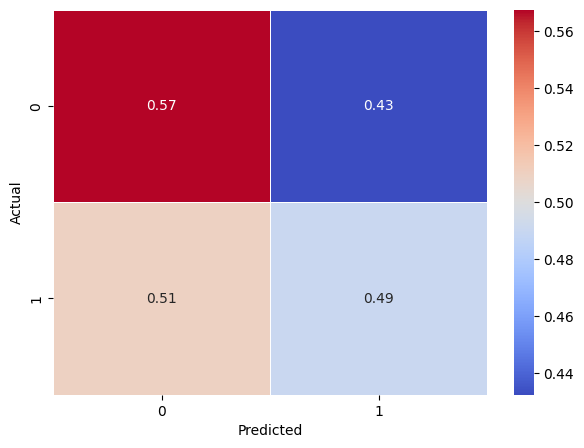

In [317]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# annot=True -> 수치데이터 표시
# cmap -> 히트맵 컬러정의
# linewidth -> 선 두께
sns.heatmap(conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 예측

In [318]:
!pip install tqdm

In [319]:
from tqdm import tqdm

In [320]:
all_recommendations = []

for resume in tqdm(resume_pool):
#for resume in tqdm(['U00001', 'U00002','U00003', 'U00004', 'U00005']):
    # 2. 임시 데이터프레임 생성
    _df_temp = pd.DataFrame({'resume_seq': [resume] * len(recruitment)})

    # 3. 전체 공고 seq를 붙임
    _df_temp['recruitment_seq'] = list(recruitment_pool)
    _df_temp.head()

    # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
    _df_train = pd.merge(_df_temp, merged_recruitment, left_on='recruitment_seq', right_on='rc_recruitment_seq', how='left')
    _df_train = pd.merge(_df_train, merged_resume, left_on='resume_seq', right_on='rs_resume_seq', how='left')
    _df_train_drop_col = ['recruitment_seq', 'rc_recruitment_seq', 'resume_seq', 'rs_resume_seq']
    _df_train.drop(_df_train_drop_col, axis = 1, inplace=True)

    # 5. 예측 확률 계산
    pred_proba = best_model.predict_proba(_df_train)[:,1]

    # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
    _df_temp['prediction'] = pred_proba
    _df_temp = _df_temp.sort_values(by='prediction', ascending=False)

    # 7. 현재 구직자의 이미 지원한 공고 가져오기
    already_applied_jobs = apply_train[apply_train['resume_seq'] == resume]['recruitment_seq'].values

    # 8. 임시 데이터프레임에서 이미 지원한 공고를 제거
    _df_temp = _df_temp[~_df_temp['recruitment_seq'].isin(already_applied_jobs)]

    # 상위 5개 추천 (이미 지원한 공고를 제외한 상위 5개)
    top_recommendations = _df_temp.head(5)

    # 결과 출력 또는 활용
    all_recommendations.append(top_recommendations)

final_recommendations = pd.concat(all_recommendations, ignore_index=True)
#final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]
final_recommendations


100%|██████████| 8482/8482 [1:20:43<00:00,  1.75it/s]


,resume_seq,recruitment_seq,prediction
0,U06995,R06572,0.873690
1,U06995,R03658,0.865573
2,U06995,R01692,0.847238
3,U06995,R02989,0.840545
4,U06995,R01597,0.840545
...,...,...,...
42405,U03927,R06572,0.870709
42406,U03927,R03658,0.863564
42407,U03927,R01692,0.845005
42408,U03927,R02989,0.838232


# 평가

In [321]:
def recall5(answer_df, submission_df):
    """
    Calculate recall@5 for given dataframes.

    Parameters:
    - answer_df: DataFrame containing the ground truth
    - submission_df: DataFrame containing the predictions

    Returns:
    - recall: Recall@5 value
    """

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    recall = np.mean(individual_recalls)
    return recall

# Result 저장 (Submission)
- Dictionary List로 sort해서 best model select

In [322]:
top_recommendations = pd.DataFrame(final_recommendations, columns=['resume_seq', 'recruitment_seq'])
top_recommendations.to_csv(args.submission_path, index=False)